# Project description

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

1. the quality of the prediction;

2. the speed of the prediction;

3. the time required for training

## Data preparation

`libraries`

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn import linear_model

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint as sp_randint


# Boosting
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, Pool, metrics, cv
import xgboost as xgb


import warnings


warnings.filterwarnings("ignore")

`data import`

In [131]:
try:
    df = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/Numerical Methods/car_data.csv')
except:
    print('Something is wrong with your data.')


`data review`

In [132]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [134]:
pd.options.display.max_columns = None
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


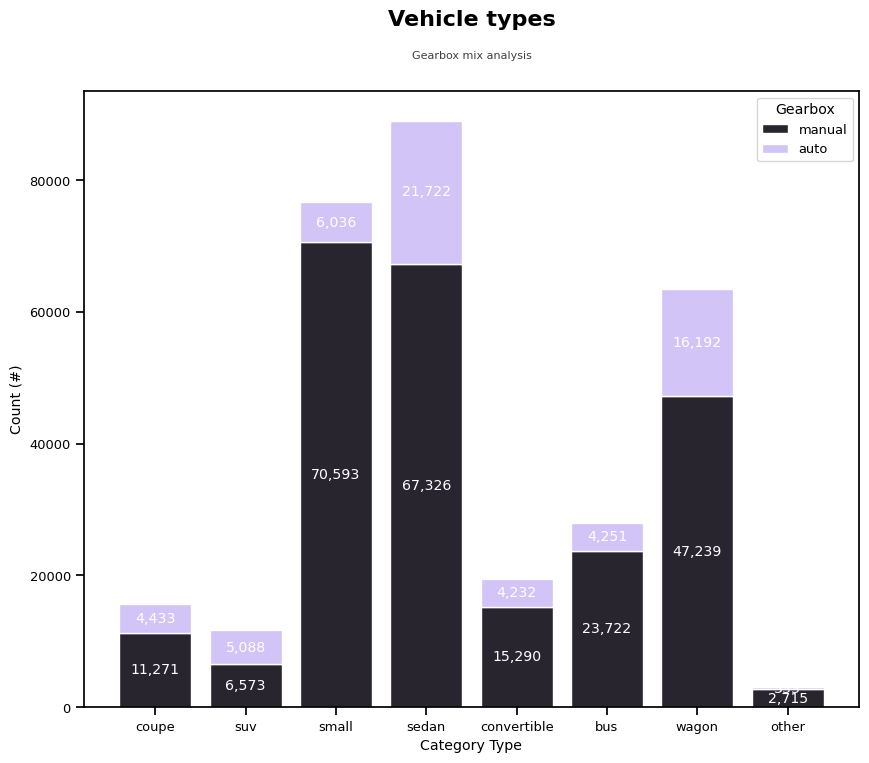

In [135]:
sns.set_context("notebook", font_scale=.85)

fig, ax = plt.subplots(figsize=(10, 8))
g = sns.countplot(data=df,
                  x='VehicleType',
                  hue='Gearbox',
                  color= '#d0bbff',
                  #palette="dark:#5A9_r",
                  ax=ax,
                  dodge=False,
                  edgecolor = "white"
                  )

ax.set(xlabel="Category Type", ylabel='Count (#)')
bottoms = {}
for bars in ax.containers:
    for bar in bars:
        x, y = bar.get_xy()
        h = bar.get_height()
        if x in bottoms:
            bar.set_y(bottoms[x])
            bottoms[x] += h
        else:
            bottoms[x] = h

for c in ax.containers:
    labels = [f'{round((v.get_height())):,}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')

ax.relim()  # the plot limits need to be updated with the moved bars
ax.autoscale()
ax.text(x=0.5, y=1.1, s='Vehicle types', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Gearbox mix analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
# sns.despine(offset=10, trim=True)

# if we need to move legend around
# h,l = ax.get_legend_handles_labels()
# ax.legend(h[:4],l[:4], bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

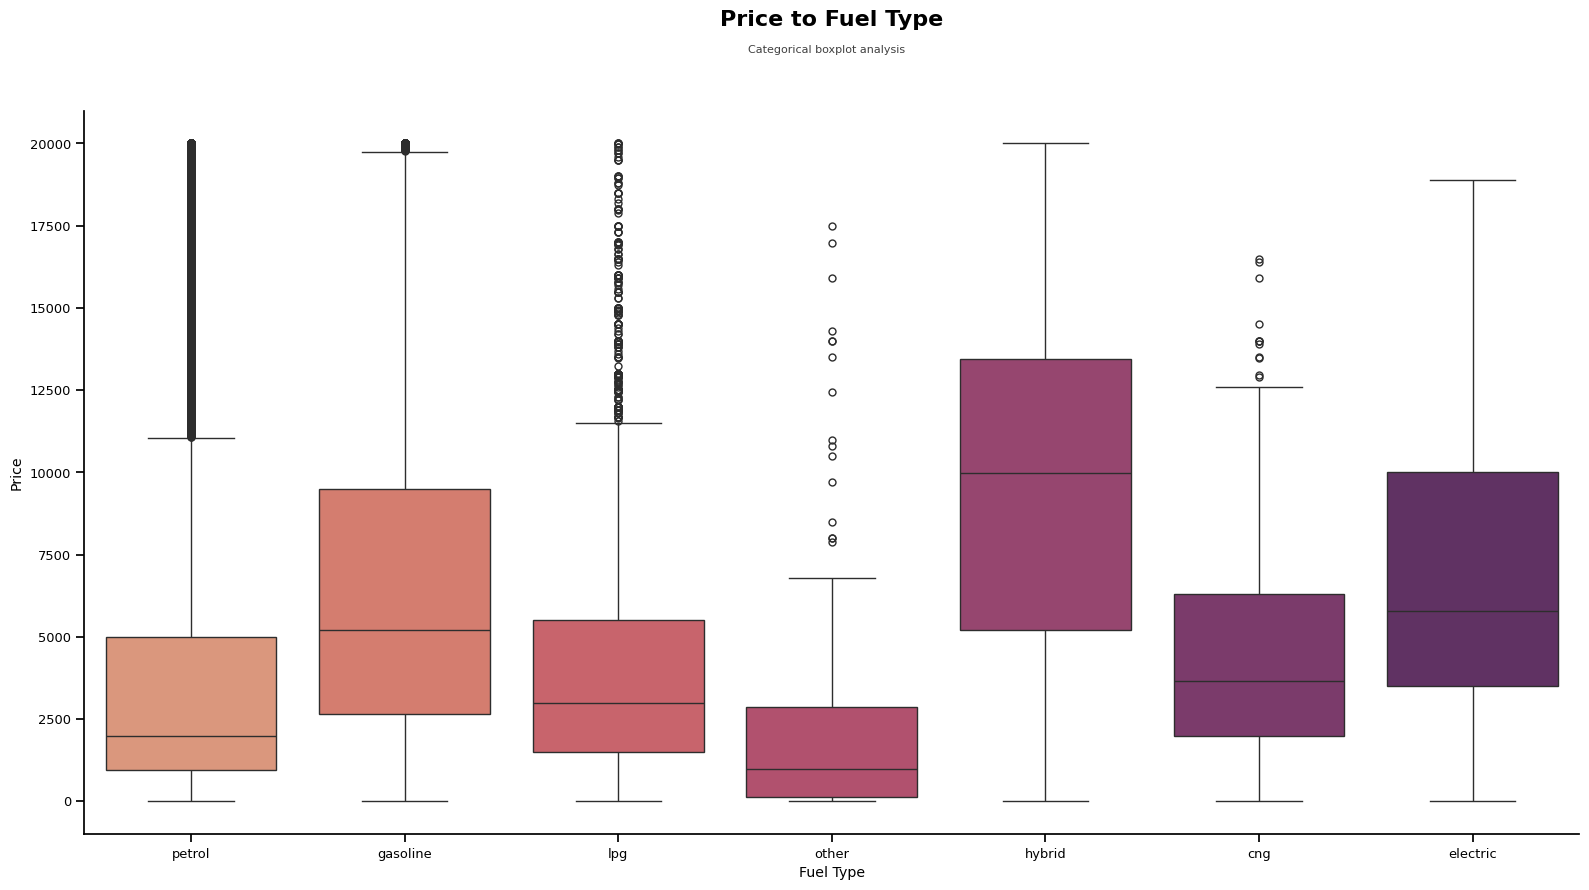

In [136]:
sns.set_context("notebook", font_scale=.85)

# fig, ax = plt.subplots(figsize=(10, 8))
g = sns.catplot(data=df,
                  x='FuelType',
                  y='Price',
                  hue='FuelType',
                  #color= '#29AB87',
                  palette="flare",
                  height=8,
                  aspect=2,
                  ax=ax,
                  kind='box',
                  legend=None,
                  native_scale=True
                  )

g.set(xlabel="Fuel Type", ylabel='Price')
plt.title('Price to Fuel Type', x=0.5, y=1.1, fontsize=16, weight='bold', ha='center', va='bottom')
g.fig.suptitle('Categorical boxplot analysis', x=0.52, y=1.05, fontsize=8, alpha=0.75, ha='center', va='bottom')
# g.fig.suptitle('Categorical boxplot analysis', x=0.5, y=1.05, fontsize=8, alpha=0.75, ha='center', va='bottom')
# sns.despine(offset=10, trim=True)

# if we need to move legend around
# h,l = ax.get_legend_handles_labels()
# ax.legend(h[:4],l[:4], bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

#### Findings

**`Findings`**


Features that should be removed / should have no material impact on analysis
    
   - DateCrawled
   
   - DateCreated
    
   - NumberOfPictures
    
   - LastSeen
    
   - RegistrationMonth / PostalCode are two others to tentitatively think about removing
    
NaN values for features like VehicleType or Model may need to be removed after checking overall impact
    
   - If needed, something worth exploring is filling in these values with values that are far away from any of their distributions so the model identifies them as 'outliers'. The null values in categorical features may be filled in with something like 'Unknown'.

Features with dtype `object` will have to be encoded for regular training using LabelEncoding then we may need to use specific methods for Gradient Boosting (attempting to run both LightGBM/CatBoost with our already encoded data)

    
Possible normalization/standardization needed *[placeholder to come back to if needed]*

In [137]:
df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode', 'RegistrationMonth'], axis=1, inplace=True)

`null value statistics`

In [138]:
correlation_filter = ['Price', 'Power', 'Mileage','RegistrationYear']

df[correlation_filter].corr()

,Price,Power,Mileage,RegistrationYear
Price,1.000000,0.158872,-0.333199,0.026916
Power,0.158872,1.000000,0.024002,-0.000828
Mileage,-0.333199,0.024002,1.000000,-0.053447
RegistrationYear,0.026916,-0.000828,-0.053447,1.000000


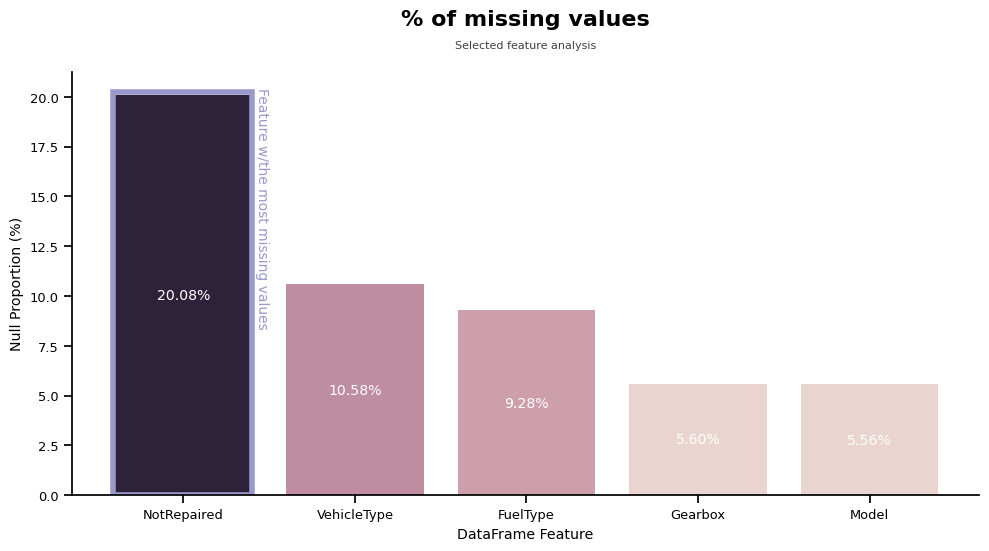

In [139]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(10)

sns.set_context("notebook", font_scale=.85)

g = sns.catplot(data=missing_data,
            x=missing_data.index,
            y='Missing Ratio',
            kind='bar',
            hue='Missing Ratio',
            height=5,
            aspect=2,
            legend=None,
            #color= '#d0bbff',
            ax=ax
            )

ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}%' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='white')

g.set(xlabel='DataFrame Feature', ylabel='Null Proportion (%)')

ax.autoscale()
ax.text(x=0.5, y=1.1, s='% of missing values', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='Selected feature analysis', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

from matplotlib.patches import Rectangle

ax.add_patch(Rectangle((-.41, 0), .81, 20.25, fill=False, edgecolor='#9999CC', lw=4))
ax.text(0.42, 8.5, "Feature w/the most missing values", fontsize = 10, color = "#9999CC", rotation = -90)
# ax.text(-.55, 21)
plt.show()

In [140]:
# Debating if we should fill in the missing values with a value

null_value_stats = df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
NotRepaired    71154
dtype: int64

`encoding`

In [141]:
class MultiColumnLabelEncoder: #OrdinalEncoder as a 2nd option
    def __init__(self,columns = None):
        self.columns = columns

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'] 
df_clean = MultiColumnLabelEncoder(columns = cat_columns).fit_transform(df)
#display(df_clean)

## Data Modeling

`data splitting`

In [142]:
features, target = df_clean.drop('Price', axis=1), df_clean.Price

# Split
# Expand to Validation set if needed
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.30,
                                                                            random_state=12345)

`tree and regression models`

In [143]:
%%time
tree_model = DecisionTreeRegressor(random_state=12345)
tree_parameters = [{'max_depth': [1, 20],
                    "splitter": ['best', 'random'],
                    'max_features': sp_randint(1, 10)}]

tree_clf = RandomizedSearchCV(tree_model, tree_parameters, cv=5)
tree_clf.fit(features_train, target_train)
print('Best Params:\n', tree_clf.best_params_)
print('')

print('')
print('Runtime:')

Best Params:
 {'max_depth': 20, 'max_features': 6, 'splitter': 'best'}


Runtime:
CPU times: user 4.98 s, sys: 194 ms, total: 5.17 s
Wall time: 5.38 s


In [144]:
%%time
tree_prediction = tree_clf.predict(features_test)
print('Prediction Time:')

Prediction Time:
CPU times: user 23 ms, sys: 2.95 ms, total: 26 ms
Wall time: 24.7 ms


In [145]:
#print('Decision Tree MSE:\n', mean_squared_error(target_test, tree_prediction))
print('Decision Tree RMSE:\n', math.sqrt(mean_squared_error(target_test, tree_prediction)))

Decision Tree RMSE:
 2169.230503059895


In [146]:
print('Feature Importance:')
{k: v for k, v in sorted(zip(tree_clf.best_estimator_.feature_names_in_, tree_clf.best_estimator_.feature_importances_), key= lambda x: x[1], reverse=True)}

Feature Importance:


{'RegistrationYear': 0.4297613245646207,
 'Power': 0.27992276063663274,
 'VehicleType': 0.09382344869666408,
 'Mileage': 0.06755290330935255,
 'Brand': 0.04406696254019353,
 'Model': 0.041411185608961835,
 'NotRepaired': 0.01895425269434896,
 'FuelType': 0.013780070452941481,
 'Gearbox': 0.010727091496284013}

In [147]:
%%time
forest_model = RandomForestRegressor(random_state=12345)
forest_parameters = [{'max_depth': [2, 10],
                      'max_features': sp_randint(1, 9)}]

forest_clf = RandomizedSearchCV(forest_model, forest_parameters, cv=5)
forest_clf.fit(features_train, target_train)
print('Best Params:\n', forest_clf.best_params_)

print('')
print('Runtime:')

Best Params:
 {'max_depth': 10, 'max_features': 6}

Runtime:
CPU times: user 4min 16s, sys: 1.3 s, total: 4min 17s
Wall time: 4min 20s


In [148]:
%%time
forest_prediction = forest_clf.predict(features_test)
print('Prediction Time:')

Prediction Time:
CPU times: user 540 ms, sys: 18.7 ms, total: 559 ms
Wall time: 672 ms


In [149]:
#print('Random Forest MSE:\n', mean_squared_error(target_test, forest_prediction))
print('Random Forest RMSE:\n', math.sqrt(mean_squared_error(target_test, forest_prediction)))

Random Forest RMSE:
 1987.0975972290366


In [150]:
print('Feature Importance:')
{k: v for k, v in sorted(zip(forest_clf.best_estimator_.feature_names_in_, forest_clf.best_estimator_.feature_importances_), key= lambda x: x[1], reverse=True)}

Feature Importance:


{'RegistrationYear': 0.47753999709088685,
 'Power': 0.3144239251984383,
 'VehicleType': 0.07748124939656151,
 'Mileage': 0.06789285725083287,
 'Brand': 0.020997341288702252,
 'NotRepaired': 0.01720371202805936,
 'Model': 0.009681431276654206,
 'FuelType': 0.007881253636895449,
 'Gearbox': 0.006898232832969224}

In [151]:
%%time
linear_model = LinearRegression()
linear_parameters = [{"positive": [True, False],
                      "fit_intercept": [True, False],
                      "n_jobs": list(range(1,9))}]

linear_clf = RandomizedSearchCV(linear_model, linear_parameters, cv=5)
linear_clf.fit(features_train, target_train)
print('Best Params:\n', linear_clf.best_params_)

print('')
print('Runtime:')

Best Params:
 {'positive': False, 'n_jobs': 8, 'fit_intercept': True}

Runtime:
CPU times: user 13.4 s, sys: 1.21 s, total: 14.6 s
Wall time: 2.16 s


In [152]:
%%time
linear_prediction = linear_clf.predict(features_test)
print('Prediction Time:')

Prediction Time:
CPU times: user 45 ms, sys: 57.6 ms, total: 103 ms
Wall time: 15.7 ms


In [153]:
#print('Linear Regression MSE:\n', mean_squared_error(target_test, linear_prediction))
print('Linear Regression RMSE:\n', math.sqrt(mean_squared_error(target_test, linear_prediction)))

Linear Regression RMSE:
 3649.711819628952


### Speed and Quality results

**`speed rankings`**

CPU Times

1. LinearRegression

2. DecisionTree

3. RandomForest


Wall Times

1. LinearRegression

2. DecisionTree

3. RandomForest    

**`quality rankings`**

RMSE
1. RandomForest

2. DecisionTree

3. LinearRegression

`boosting models`

Gradient Boosting

- LightGBM grows leaf-wise while XGBoost grows level-wise

- LightGBM expects categorical features converted to integer

In [154]:
%%time
## Test #1
x_train, y_train = features_train.values, target_train.values
x_test, y_test = features_test.values, target_test.values


lgb_features = df_clean[['RegistrationYear', 'Power', 'Mileage']]
lgb_categorical_features = df_clean[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

lgb_train = lgb.Dataset(x_train, 
                        y_train, 
                        feature_name = lgb_features, 
                        categorical_feature = lgb_categorical_features)
print('')
print('Runtime:')


Runtime:
CPU times: user 115 ms, sys: 21.2 ms, total: 136 ms
Wall time: 57.2 ms


In [155]:
%%time
lgb_parameters = {
'task': 'train'    
, 'learning_rate': '0.1'
, 'boosting_type': 'gbdt'
, 'random_state': 12345
, 'n_estimators': 150
, 'max_depth': 10
, 'num_leaves': 100
}
 
gbm = lgb.LGBMRegressor(**lgb_parameters)

gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l1',
        #early_stopping_rounds=150
        )

print('')
print('Runtime:')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 248058, number of used features: 9
[LightGBM] [Info] Start training from score 4414.500871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Runtime:
CPU times: user 3.34 s, sys: 2.22 s, total: 5.56 s
Wall time: 2.18 s


In [156]:
%%time
lgb_prediction = gbm.predict(x_test, num_iteration = gbm.best_iteration_)
print('Prediction Time:')

Prediction Time:
CPU times: user 1.31 s, sys: 6.19 ms, total: 1.32 s
Wall time: 225 ms


In [157]:
print('LGBM Regression RMSE:\n', math.sqrt(mean_squared_error(target_test, lgb_prediction)))

LGBM Regression RMSE:
 1744.1493198780586


`Alternate LightGBM model`

In [158]:
%%time
## Test #2
lgbm_model = lgb.LGBMRegressor()
lgbm_model.fit(features_train, target_train)
print('')
print('Runtime:')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 248058, number of used features: 9
[LightGBM] [Info] Start training from score 4414.500871

Runtime:
CPU times: user 1.08 s, sys: 538 ms, total: 1.62 s
Wall time: 604 ms


In [159]:
%%time
lgbm_prediction = lgbm_model.predict(features_test)
print('Prediction Time:')

Prediction Time:
CPU times: user 716 ms, sys: 4.89 ms, total: 720 ms
Wall time: 129 ms


In [160]:
print('LGBM Regression RMSE v2:\n', math.sqrt(mean_squared_error(target_test, lgbm_prediction)))

LGBM Regression RMSE v2:
 1854.5291137206434


`CatBoost`

In [161]:
#print(cat_features.dtypes)

categorical_features_indices = np.where(features.dtypes != float)[0]

#print(categorical_features_indices)

In [162]:
%%time
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    learning_rate=0.1,
    random_seed=12345,
    logging_level='Silent'
)
print('')
print('Runtime:')


Runtime:
CPU times: user 100 µs, sys: 788 µs, total: 888 µs
Wall time: 4.6 ms


In [163]:
%%time
cat_model.fit(
    features_train, target_train,
    cat_features = categorical_features_indices,
    eval_set = (features_test, target_test),
    plot = True
);

print('')
print('Runtime:')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Runtime:
CPU times: user 5min 41s, sys: 11 s, total: 5min 52s
Wall time: 57.3 s


In [164]:
# cat_model_predict = cat_model.predict(features_test)

print('CatBoost # of Trees:\n', cat_model.tree_count_)
print('')
print('CatBoost Best Score\n', cat_model.best_score_)
print('')
print('CatBoost Best Iteration\n', cat_model.best_iteration_)

CatBoost # of Trees:
 1000

CatBoost Best Score
 {'learn': {'RMSE': 1745.3986035884266}, 'validation': {'RMSE': 1787.6356729143824}}

CatBoost Best Iteration
 999


`XGBoost`

Regression Matrices

- `enable_categorical` set to True in order to enable automatic encoding

In [165]:
xg_features, xg_target = df.drop('Price', axis=1), df.Price

cats = xg_features.select_dtypes(exclude=np.number).columns.tolist()

for col in cats:
    xg_features[col] = xg_features[col].astype('category')

xg_features.dtypes

VehicleType         category
RegistrationYear       int64
Gearbox             category
Power                  int64
Model               category
Mileage                int64
FuelType            category
Brand               category
NotRepaired         category
dtype: object

In [166]:
xg_features_train, xg_features_test, xg_target_train, xg_target_test = train_test_split(xg_features,
                                                                            xg_target,
                                                                            test_size=0.30,
                                                                            random_state=12345)

In [167]:
train_reg = xgb.DMatrix(xg_features_train, xg_target_train, enable_categorical=True)
test_reg = xgb.DMatrix(xg_features_test, xg_target_test, enable_categorical=True)

In [168]:
%%time
xg_parameters = {"objective": "reg:squarederror",
                 "tree_method": "hist"}

n = 1000

evals = [(test_reg, "validation"), (train_reg, "train")]

xg_model = xgb.train(
   params=xg_parameters,
   evals=evals, 
   dtrain=train_reg,
   num_boost_round=n,
   verbose_eval=50,
   early_stopping_rounds=50
)
print('')
print('Runtime:')

[0]	validation-rmse:3565.17784	train-rmse:3564.07713
[50]	validation-rmse:1769.39274	train-rmse:1646.31562
[100]	validation-rmse:1743.36519	train-rmse:1567.68305
[150]	validation-rmse:1731.61214	train-rmse:1518.91904
[200]	validation-rmse:1727.69418	train-rmse:1484.78806
[250]	validation-rmse:1725.54360	train-rmse:1457.67458
[300]	validation-rmse:1722.82048	train-rmse:1432.61493
[350]	validation-rmse:1721.62929	train-rmse:1415.01014
[400]	validation-rmse:1721.36798	train-rmse:1397.45673
[450]	validation-rmse:1722.56378	train-rmse:1382.16856
[500]	validation-rmse:1724.45110	train-rmse:1370.70399
[550]	validation-rmse:1726.03583	train-rmse:1358.72930
[600]	validation-rmse:1725.66822	train-rmse:1346.56491
[650]	validation-rmse:1726.22957	train-rmse:1335.82350
[700]	validation-rmse:1726.66076	train-rmse:1324.99066
[750]	validation-rmse:1726.38087	train-rmse:1314.32339
[800]	validation-rmse:1727.09273	train-rmse:1305.44453
[850]	validation-rmse:1727.37955	train-rmse:1297.58103
[900]	validat

In [169]:
%%time
xg_prediction = xg_model.predict(test_reg)
print('Prediction Time:')

Prediction Time:
CPU times: user 7.11 s, sys: 57.9 ms, total: 7.17 s
Wall time: 990 ms


In [170]:
print('XGBoost RMSE:\n', math.sqrt(mean_squared_error(xg_target_test, xg_prediction)))

XGBoost RMSE:
 1730.1556842679684


## Conclusions


1. Based on our initial analysis, the initial model with the best quality will be our RandomForest model with an RMSE of ~1,985 (considerably better than our LinearRegression model benchmark with an RMSE of ~3,649.

    - With that said, when it comes to speed, our RandomForest model is the worst performing with a time of about 6 minutes compared to our DecisionTree and LinearRegression models with times in the seconds.
    
    - Rusty Bargain will have to come to some sort of compromise/decision when it comes to our quality vs speed metrics.
    
    
2. Once Gradient Boosting is introduced, we see our RMSE values improve as both the LightGBM and CatBoost boosting techniques yield a scores of the range of ~1,700-1,800. Speed for both boosting methods are in the seconds or near the minute mark.


3. Leveraging XGBoost, our RMSE value is slightly higher than LGBM/CatBoost but more or less pretty similar.                             
    

4. Lastly, when it comes to boosting, the speed rankings are as follows: a) LightGBM, b) XGBoost and c) CatBoost while the quality rankings are the following: a) LightGBM, b) CatBoost and c) XGBoost.

 